In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer

In [3]:
data = pd.read_csv('/Users/beckettdowhan/Downloads/data_cleaned.csv', low_memory=False)

In [31]:
# Separate swing from take data 
# Going to build two separate models
swing_data = data[data['Swing/Take'] == 'Swing']
take_data = data[data['Swing/Take'] == 'Take']

In [33]:
X_swing = swing_data[['Count', 'PlateLocHeight', 'PlateLocSide']]
y_swing = swing_data['target']
X_take = take_data[['Count', 'PlateLocHeight', 'PlateLocSide']]
y_take = take_data['target']

In [37]:
#  SWING MODEL

# Define features
columns_to_scale = ['PlateLocHeight', 'PlateLocSide']
columns_to_leave = ['Count']

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), columns_to_scale),
        ('passthrough', 'passthrough', columns_to_leave)
    ]
)

# Base model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Hyperparameter grid (lightweight for speed)
param_dist = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])

# RandomizedSearchCV (limited to 10 combinations for speed)
random_search = RandomizedSearchCV(
    pipeline, param_distributions={'model__' + k: v for k, v in param_dist.items()},
    n_iter=10, cv=3, verbose=1, scoring='r2', n_jobs=-1, random_state=42
)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_swing, y_swing, test_size=0.2, random_state=42)

# Fit model with hyperparameter tuning
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

# Cross-validated R² score
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2')
print(f"Cross-Validated R²: {cv_scores.mean():.4f}")

# Test evaluation
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest Data Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Cross-Validated R²: 0.3607

Test Data Metrics:
Mean Squared Error (MSE): 0.0043
Mean Absolute Error (MAE): 0.0570
R-squared (R²): 0.3570

Best Model Parameters:
{'model__subsample': 0.7, 'model__n_estimators': 150, 'model__max_depth': 5, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.7}


The low R^2 score of .357 isn't too concerning. Baseball swings are very noisy and bad swing decisions can sometimes lead to runs scored. The take model will be much easier to predict because it's going to be more concentrated on pitch location. All in all, the MSE and MAE are good indicators that the model is working well.

In [48]:
# TAKE MODEL

# Split
X_train, X_test, y_train, y_test = train_test_split(X_take, y_take, test_size=0.2, random_state=42)

# Train with tuning
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

# Cross-validation
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2')
print(f"\nCross-Validated R²: {cv_scores.mean():.4f}")

# Test evaluation
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest Data Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Train evaluation
y_pred_train = best_model.predict(X_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print("\nTraining Data Metrics:")
print(f"Mean Squared Error (MSE): {mse_train:.4f}")
print(f"R-squared (R²): {r2_train:.4f}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Cross-Validated R²: 0.6945

Test Data Metrics:
Mean Squared Error (MSE): 0.0027
Mean Absolute Error (MAE): 0.0271
R-squared (R²): 0.7023

Training Data Metrics:
Mean Squared Error (MSE): 0.0027
R-squared (R²): 0.7038


Variability is much better explained for pitches where the player didn't swing. The model can rely heavily on ball location.

In [62]:
# Now we can test our model on new data
report = pd.read_csv('/Users/beckettdowhan/Downloads/baseball_100k_target.csv')

/var/folders/vj/mr9gtxyd13s7vdvt74wwnw3h0000gn/T/ipykernel_4351/435736486.py:2: DtypeWarning: Columns (93,94) have mixed types. Specify dtype option on import or set low_memory=False.
  report = pd.read_csv('/Users/beckettdowhan/Downloads/baseball_100k_target.csv')


In [64]:
report.head(10)

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,...,runners_on_2nd,runners_on_3rd,runners_code,count_code,tot_runs_scored,ERV_pre,ERV_post,ERV_delta,pitch_type,target
0,1,2022-02-18,13:32:19.860000,1,1,"Kniskern, Trevor",1.000054e+09,Right,PEP_WAV,"Rotondo, Chris",...,0,0,0,5,0,0.008051,0.010597,0.002546,4,0.013403
1,2,2022-02-18,13:32:36,1,2,"Kniskern, Trevor",1.000054e+09,Right,PEP_WAV,"Rotondo, Chris",...,0,0,0,6,0,0.010597,0.010826,0.000228,4,0.004572
2,3,2022-02-18,13:33:12.450000,1,3,"Kniskern, Trevor",1.000054e+09,Right,PEP_WAV,"Rotondo, Chris",...,0,0,0,4,0,0.010826,0.009554,-0.001272,4,0.198844
3,4,2022-02-18,13:33:53.170000,2,1,"Kniskern, Trevor",1.000054e+09,Right,PEP_WAV,"O'Neill, Pat",...,0,0,0,5,0,0.009554,0.012952,0.003398,4,0.004572
4,5,2022-02-18,13:34:10.280000,2,2,"Kniskern, Trevor",1.000054e+09,Right,PEP_WAV,"O'Neill, Pat",...,0,0,0,2,0,0.012952,0.014217,0.001265,2,0.013403
5,6,2022-02-18,13:34:29.800000,2,3,"Kniskern, Trevor",1.000054e+09,Right,PEP_WAV,"O'Neill, Pat",...,0,0,0,4,0,0.014217,0.012858,-0.001359,4,0.004572
6,7,2022-02-18,13:34:50.360000,2,4,"Kniskern, Trevor",1.000054e+09,Right,PEP_WAV,"O'Neill, Pat",...,0,0,0,1,0,0.012858,0.012858,0.000000,2,0.003130
7,8,2022-02-18,13:35:24.420000,2,5,"Kniskern, Trevor",1.000054e+09,Right,PEP_WAV,"O'Neill, Pat",...,0,0,0,1,0,0.012858,0.025722,0.012864,2,0.198844
8,9,2022-02-18,13:36:11.690000,3,1,"Kniskern, Trevor",1.000054e+09,Right,PEP_WAV,"O'Reilly, Jack",...,0,0,1,5,0,0.025722,0.034688,0.008965,4,-0.006111
9,10,2022-02-18,13:36:36.900000,3,2,"Kniskern, Trevor",1.000054e+09,Right,PEP_WAV,"O'Reilly, Jack",...,0,0,1,2,0,0.034688,0.041041,0.006353,4,0.004572


In [66]:
report.rename(columns={'count_code': 'Count'}, inplace=True)

In [68]:
report['swing_value'] = pipeline_swing.predict(report)
report['take_value'] = pipeline_take.predict(report)

In [74]:
# Manually located some good at-bats to test our model on
sample_report = report.iloc[8:14]
sample_report[['PitchNo','Balls', 'Strikes', 'Swing/Take', 'PlayResult', 'PitchCall', 'swing_value', 'take_value', 'PlateLocSide', 'PlateLocHeight']]

,PitchNo,Balls,Strikes,Swing/Take,PlayResult,PitchCall,swing_value,take_value,PlateLocSide,PlateLocHeight
8,9,0,0,Swing,Undefined,StrikeSwinging,-0.054239,0.049689,-0.53552,3.49811
9,10,0,1,Take,Undefined,StrikeCalled,-0.017894,-0.026396,-1.09709,2.28773
10,11,0,2,Swing,Undefined,FoulBall,0.090542,-0.040417,-0.37454,2.31181
11,12,0,2,Take,Undefined,BallCalled,0.047230,0.067648,-1.57688,1.94192
12,13,1,2,Take,Undefined,BallCalled,-0.012685,0.085695,-2.53747,-0.01803
13,14,2,2,Swing,Out,InPlay,0.016234,0.001035,-1.05382,1.94066


In [76]:
sample_report2 = report.iloc[27:33]

In [78]:
sample_report3 = report.iloc[162:165]

In [80]:
sample_report3[['Balls', 'Strikes', 'Swing/Take', 'PlayResult', 'PitchCall', 'swing_value', 'take_value', 'PlateLocSide', 'PlateLocHeight']]

,Balls,Strikes,Swing/Take,PlayResult,PitchCall,swing_value,take_value,PlateLocSide,PlateLocHeight
162,0,0,Take,Undefined,StrikeCalled,-0.035026,-0.062131,-0.77517,2.85328
163,0,1,Swing,Undefined,FoulBall,0.005675,-0.083402,0.33346,2.29557
164,0,2,Take,Undefined,StrikeCalled,0.073553,-0.014274,-0.93111,2.49596


In [82]:
# Add a decision_value column based on Swing/Take
sample_report['decision_value'] = sample_report.apply(
    lambda row: row['swing_value'] if row['Swing/Take'] == 'Swing' else row['take_value'], axis=1
)

# Calculate the swing score for the at-bat
swing_score = sample_report['decision_value'].sum()

/var/folders/vj/mr9gtxyd13s7vdvt74wwnw3h0000gn/T/ipykernel_4351/206482202.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_report['decision_value'] = sample_report.apply(


In [84]:
# Add a decision_value column based on Swing/Take
sample_report2['decision_value'] = sample_report2.apply(
    lambda row: row['swing_value'] if row['Swing/Take'] == 'Swing' else row['take_value'], axis=1
)

# Calculate the swing score for the at-bat
swing_score2 = sample_report2['decision_value'].sum()


/var/folders/vj/mr9gtxyd13s7vdvt74wwnw3h0000gn/T/ipykernel_4351/3008856811.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_report2['decision_value'] = sample_report2.apply(


In [86]:
# Add a decision_value column based on Swing/Take
sample_report3['decision_value'] = sample_report3.apply(
    lambda row: row['swing_value'] if row['Swing/Take'] == 'Swing' else row['take_value'], axis=1
)

# Calculate the swing score for the at-bat
swing_score3 = sample_report3['decision_value'].sum()

/var/folders/vj/mr9gtxyd13s7vdvt74wwnw3h0000gn/T/ipykernel_4351/3732833522.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_report3['decision_value'] = sample_report3.apply(


/var/folders/vj/mr9gtxyd13s7vdvt74wwnw3h0000gn/T/ipykernel_4351/1134528784.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


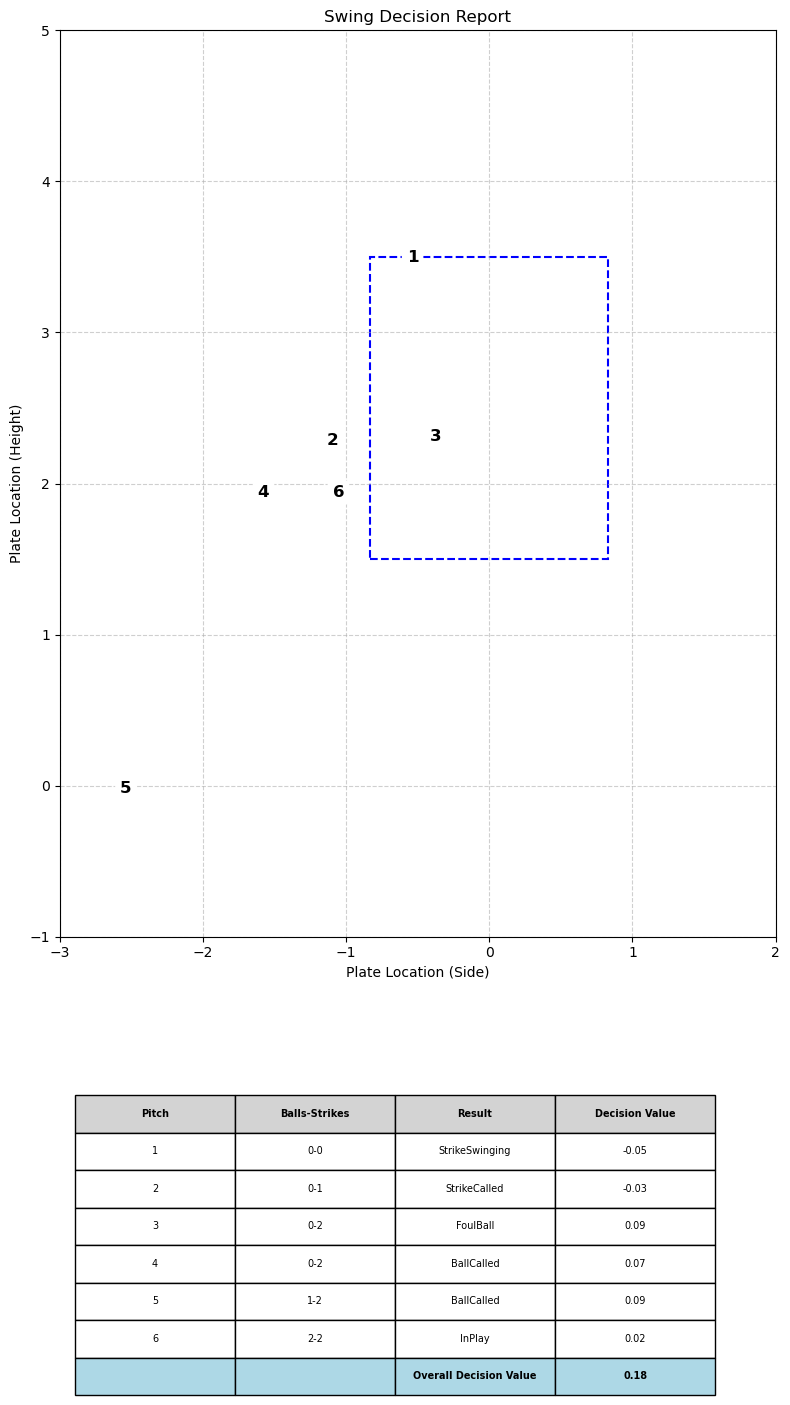

In [88]:
from matplotlib.table import Table

# Reset index to ensure proper sequential numbering from 1 to 6
sample_report = sample_report.reset_index(drop=True)

# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(8, 10))

# Define strike zone boundaries
strike_zone_x_min = -0.833
strike_zone_x_max = 0.833
strike_zone_y_min = 1.5
strike_zone_y_max = 3.5

# Adjust plotting bounds to ensure all pitches are visible
ax.set_xlim(-3, 2)  # Expand based on PlateLocSide range
ax.set_ylim(-1, 5)   # Expand based on PlateLocHeight range


# Plot each pitch and annotate with pitch number
for idx, row in sample_report.iterrows():
    color = 'green' if row['Swing/Take'] == 'Swing' else 'red'  # Color for swing/take
    pitch_number = idx + 1  # Number pitches 1 through 6
    
    # Plot the dot
    ax.scatter(row['PlateLocSide'], row['PlateLocHeight'], color=color, s=100, edgecolor='black')
    
    # Annotate with a bold number and a white background
    ax.text(row['PlateLocSide'], row['PlateLocHeight'], 
            str(pitch_number), 
            fontsize=12,  # Larger font size
            fontweight='bold',  # Bold font
            color='black',  # Black text color
            ha='center', va='center',  # Center alignment
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))  # Add a white background



# Add the strike zone rectangle
strike_zone = plt.Rectangle((strike_zone_x_min, strike_zone_y_min), 
                             strike_zone_x_max - strike_zone_x_min, 
                             strike_zone_y_max - strike_zone_y_min,
                             edgecolor='blue', facecolor='none', linestyle='--', linewidth=1.5)
ax.add_patch(strike_zone)

# Customize the plot
ax.set_title(f"Swing Decision Report")
ax.set_xlabel('Plate Location (Side)')
ax.set_ylabel('Plate Location (Height)')
ax.grid(True, linestyle='--', alpha=0.6)

# Add the table below the plot
table_data = [['Pitch', 'Balls-Strikes', 'Result', 'Decision Value']]
for idx, row in sample_report.iterrows():
    pitch_number = idx + 1
    table_data.append([
        pitch_number, 
        f"{row['Balls']}-{row['Strikes']}",
        row['PitchCall'],  # Use the value from the PitchCall column
        f"{row['decision_value']:.2f}"
    ])

# Calculate the overall decision value
overall_decision_value = sample_report['decision_value'].sum()
table_data.append(["", "", "Overall Decision Value", f"{overall_decision_value:.2f}"])

# Create the table
table_ax = fig.add_axes([0.1, -0.4, 0.8, 0.3])  # Adjust position and size as needed
table_ax.axis('off')
pitch_table = Table(table_ax, bbox=[0, 0, 1, 1])

# Add cells to the table
n_rows = len(table_data)
n_cols = len(table_data[0])
cell_width = 1.0 / n_cols
cell_height = 1.0 / n_rows

for i, row in enumerate(table_data):
    for j, cell_value in enumerate(row):
        cell = pitch_table.add_cell(i, j, width=cell_width, height=cell_height, text=cell_value, loc='center', facecolor='white')
        if i == 0:  # Header row
            cell.set_facecolor('lightgrey')
            cell.set_text_props(fontsize=10, fontweight='bold')  # Correct method for font properties
        if i == len(table_data) - 1:  # Bottom row for overall decision value
            cell.set_facecolor('lightblue')
            cell.set_text_props(fontsize=10, fontweight='bold')
        cell.set_edgecolor('black')

# Add the table to the axes
table_ax.add_table(pitch_table)

# Show the plot
plt.tight_layout()
plt.show()


/var/folders/vj/mr9gtxyd13s7vdvt74wwnw3h0000gn/T/ipykernel_12086/64165520.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


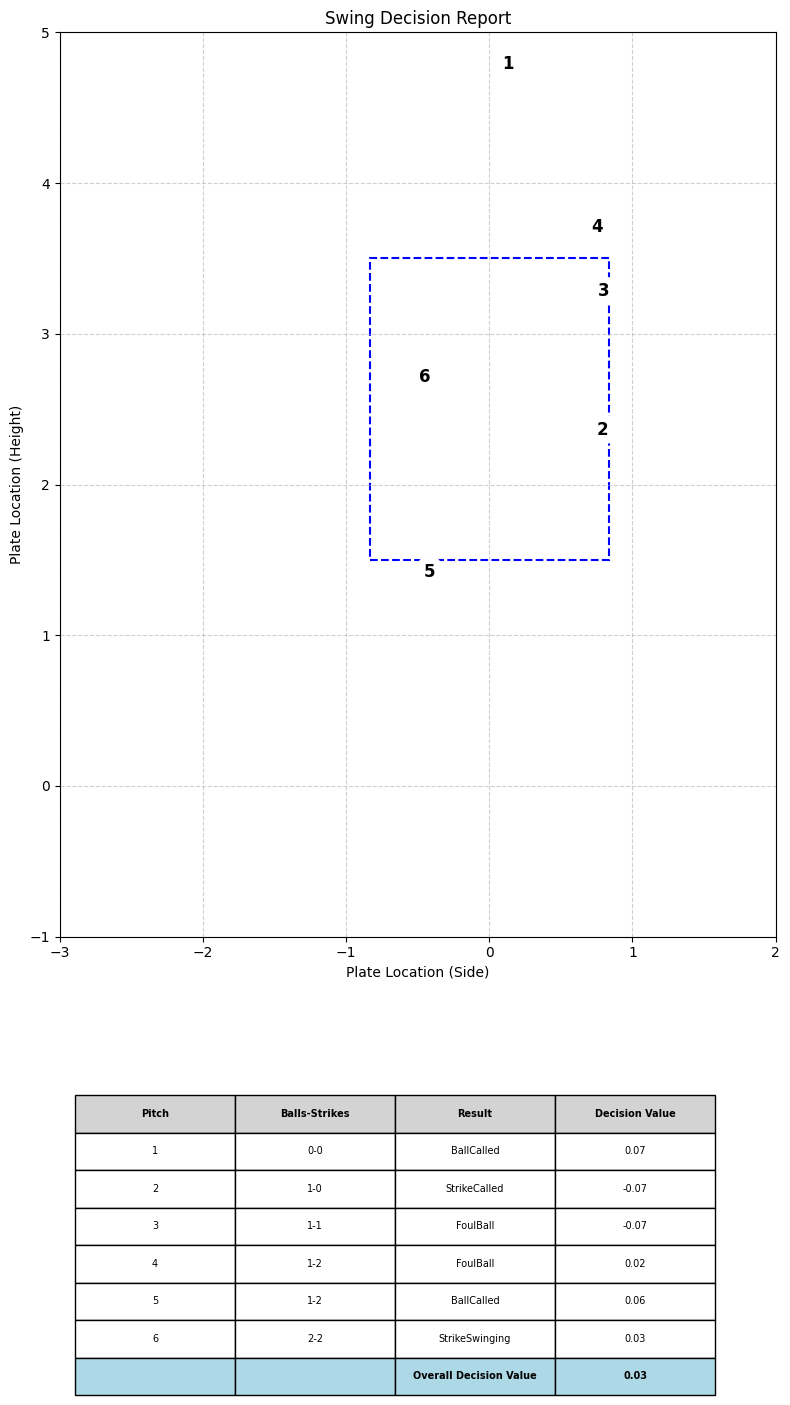

In [240]:
import matplotlib.pyplot as plt
from matplotlib.table import Table

# Reset index to ensure proper sequential numbering from 1 to 6
sample_report2 = sample_report2.reset_index(drop=True)

# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(8, 10))

# Define strike zone boundaries
strike_zone_x_min = -0.833
strike_zone_x_max = 0.833
strike_zone_y_min = 1.5
strike_zone_y_max = 3.5

# Adjust plotting bounds to ensure all pitches are visible
ax.set_xlim(-3, 2)  # Expand based on PlateLocSide range
ax.set_ylim(-1, 5)   # Expand based on PlateLocHeight range

# Plot each pitch and annotate with pitch number
for idx, row in sample_report2.iterrows():
    color = 'green' if row['Swing/Take'] == 'Swing' else 'red'  # Color for swing/take
    pitch_number = idx + 1  # Number pitches 1 through 6
    
    # Plot the dot
    ax.scatter(row['PlateLocSide'], row['PlateLocHeight'], color=color, s=100, edgecolor='black')
    
    # Annotate with a bold number and a white background
    ax.text(row['PlateLocSide'], row['PlateLocHeight'], 
            str(pitch_number), 
            fontsize=12,  # Larger font size
            fontweight='bold',  # Bold font
            color='black',  # Black text color
            ha='center', va='center',  # Center alignment
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))  # Add a white background

# Add the strike zone rectangle
strike_zone = plt.Rectangle((strike_zone_x_min, strike_zone_y_min), 
                             strike_zone_x_max - strike_zone_x_min, 
                             strike_zone_y_max - strike_zone_y_min,
                             edgecolor='blue', facecolor='none', linestyle='--', linewidth=1.5)
ax.add_patch(strike_zone)

# Customize the plot
ax.set_title(f"Swing Decision Report")
ax.set_xlabel('Plate Location (Side)')
ax.set_ylabel('Plate Location (Height)')
ax.grid(True, linestyle='--', alpha=0.6)

# Add the table below the plot
table_data = [['Pitch', 'Balls-Strikes', 'Result', 'Decision Value']]
for idx, row in sample_report2.iterrows():
    pitch_number = idx + 1
    table_data.append([
        pitch_number, 
        f"{row['Balls']}-{row['Strikes']}",
        row['PitchCall'],
        f"{row['decision_value']:.2f}"
    ])

# Calculate the overall decision value
overall_decision_value = sample_report2['decision_value'].sum()
table_data.append(["", "", "Overall Decision Value", f"{overall_decision_value:.2f}"])

# Create the table
table_ax = fig.add_axes([0.1, -0.4, 0.8, 0.3])  # Adjust position and size as needed
table_ax.axis('off')
pitch_table = Table(table_ax, bbox=[0, 0, 1, 1])

# Add cells to the table
n_rows = len(table_data)
n_cols = len(table_data[0])
cell_width = 1.0 / n_cols
cell_height = 1.0 / n_rows

for i, row in enumerate(table_data):
    for j, cell_value in enumerate(row):
        cell = pitch_table.add_cell(i, j, width=cell_width, height=cell_height, text=cell_value, loc='center', facecolor='white')
        if i == 0:  # Header row
            cell.set_facecolor('lightgrey')
            cell.set_text_props(fontsize=10, fontweight='bold')  # Correct method for font properties
        if i == len(table_data) - 1:  # Bottom row for overall decision value
            cell.set_facecolor('lightblue')
            cell.set_text_props(fontsize=10, fontweight='bold')
        cell.set_edgecolor('black')

# Add the table to the axes
table_ax.add_table(pitch_table)

# Show the plot
plt.tight_layout()
plt.show()

/var/folders/vj/mr9gtxyd13s7vdvt74wwnw3h0000gn/T/ipykernel_4351/579363597.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


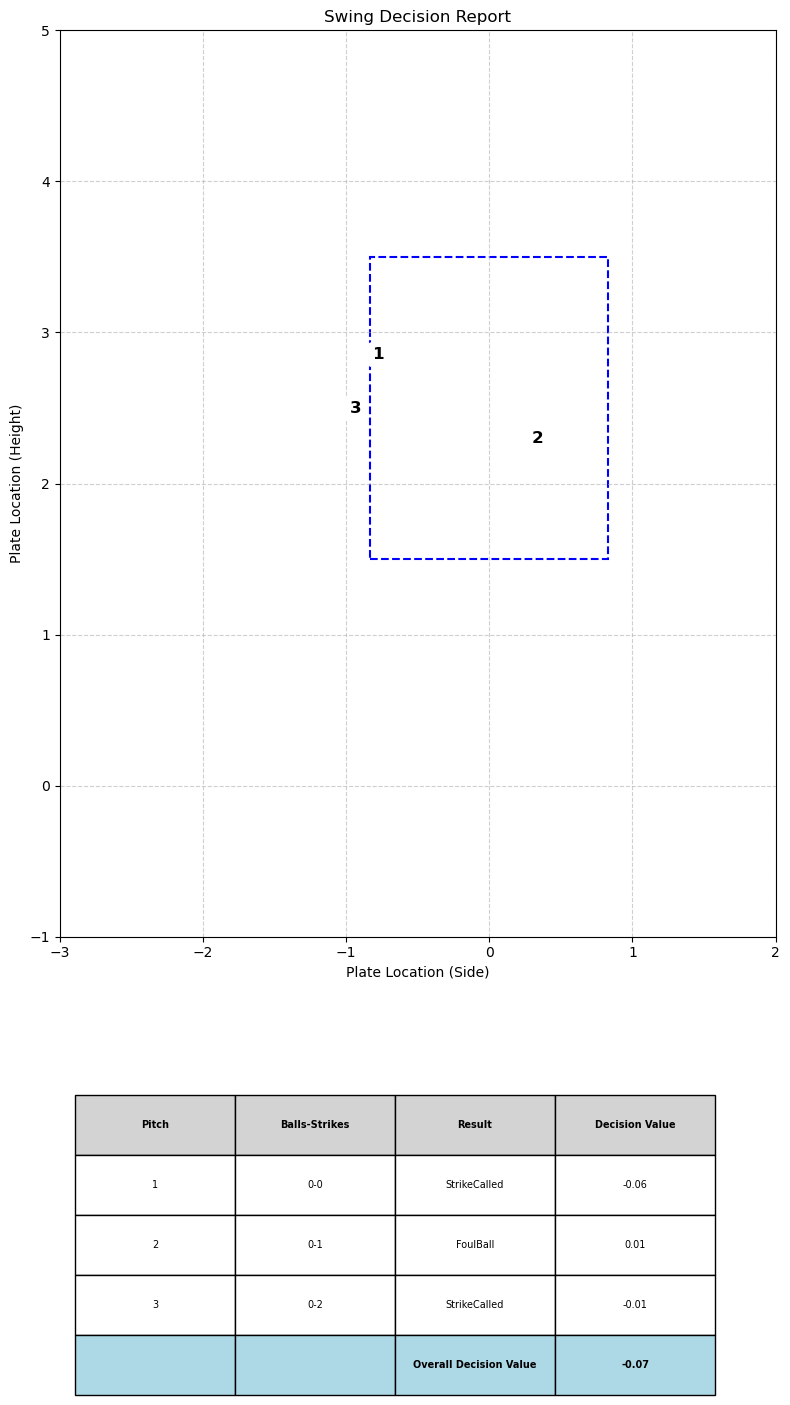

In [90]:
import matplotlib.pyplot as plt
from matplotlib.table import Table

# Reset index to ensure proper sequential numbering from 1 to 6
sample_report3 = sample_report3.reset_index(drop=True)

# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(8, 10))

# Define strike zone boundaries
strike_zone_x_min = -0.833
strike_zone_x_max = 0.833
strike_zone_y_min = 1.5
strike_zone_y_max = 3.5

# Adjust plotting bounds to ensure all pitches are visible
ax.set_xlim(-3, 2)  # Expand based on PlateLocSide range
ax.set_ylim(-1, 5)   # Expand based on PlateLocHeight range


# Plot each pitch and annotate with pitch number
for idx, row in sample_report3.iterrows():
    color = 'green' if row['Swing/Take'] == 'Swing' else 'red'  # Color for swing/take
    pitch_number = idx + 1  # Number pitches 1 through 6
    
    # Plot the dot
    ax.scatter(row['PlateLocSide'], row['PlateLocHeight'], color=color, s=100, edgecolor='black')
    
    # Annotate with a bold number and a white background
    ax.text(row['PlateLocSide'], row['PlateLocHeight'], 
            str(pitch_number), 
            fontsize=12,  # Larger font size
            fontweight='bold',  # Bold font
            color='black',  # Black text color
            ha='center', va='center',  # Center alignment
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))  # Add a white background



# Add the strike zone rectangle
strike_zone = plt.Rectangle((strike_zone_x_min, strike_zone_y_min), 
                             strike_zone_x_max - strike_zone_x_min, 
                             strike_zone_y_max - strike_zone_y_min,
                             edgecolor='blue', facecolor='none', linestyle='--', linewidth=1.5)
ax.add_patch(strike_zone)

# Customize the plot
ax.set_title(f"Swing Decision Report")
ax.set_xlabel('Plate Location (Side)')
ax.set_ylabel('Plate Location (Height)')
ax.grid(True, linestyle='--', alpha=0.6)

# Add the table below the plot
table_data = [['Pitch', 'Balls-Strikes', 'Result', 'Decision Value']]
for idx, row in sample_report3.iterrows():
    pitch_number = idx + 1
    table_data.append([
        pitch_number, 
        f"{row['Balls']}-{row['Strikes']}",
        row['PitchCall'],  # Use the value from the PitchCall column
        f"{row['decision_value']:.2f}"
    ])

# Calculate the overall decision value
overall_decision_value = sample_report3['decision_value'].sum()
table_data.append(["", "", "Overall Decision Value", f"{overall_decision_value:.2f}"])

# Create the table
table_ax = fig.add_axes([0.1, -0.4, 0.8, 0.3])  # Adjust position and size as needed
table_ax.axis('off')
pitch_table = Table(table_ax, bbox=[0, 0, 1, 1])

# Add cells to the table
n_rows = len(table_data)
n_cols = len(table_data[0])
cell_width = 1.0 / n_cols
cell_height = 1.0 / n_rows

for i, row in enumerate(table_data):
    for j, cell_value in enumerate(row):
        cell = pitch_table.add_cell(i, j, width=cell_width, height=cell_height, text=cell_value, loc='center', facecolor='white')
        if i == 0:  # Header row
            cell.set_facecolor('lightgrey')
            cell.set_text_props(fontsize=10, fontweight='bold')  # Correct method for font properties
        if i == len(table_data) - 1:  # Bottom row for overall decision value
            cell.set_facecolor('lightblue')
            cell.set_text_props(fontsize=10, fontweight='bold')
        cell.set_edgecolor('black')

# Add the table to the axes
table_ax.add_table(pitch_table)

# Show the plot
plt.tight_layout()
plt.show()